# Explainable AI for the Classification of Breast Cancer

### *Author: Sahitya Tripathy*

In [1]:
# 1. Imports & Environment Checks

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# For XAI
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# Check Python and library versions for reproducibility
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")
import explainerdashboard
print(f"ExplainerDashboard version: {explainerdashboard.__version__}")

Python version: 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 12:58:53) [MSC v.1929 64 bit (AMD64)]
Pandas version: 2.2.3
Numpy version: 1.26.4
Scikit-learn version: 1.5.1
ExplainerDashboard version: 0.5.1


In [2]:
# 2. Data Loading and Initial Exploration

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='label')

print("Dataset shape:", X.shape)
print("Classes:", dict(enumerate(data.target_names)))
print("Class distribution:\n", y.value_counts().rename(index=dict(enumerate(data.target_names))))

# Merge X and y for easy exploration
df = X.copy()
df['label'] = y

# Show basic info
print("\nData info:")
display(X.info())
display(X.head())

# Check for missing values
missing_vals = X.isnull().sum().sum()
print(f"\nMissing values in features: {missing_vals}")

Dataset shape: (569, 30)
Classes: {0: 'malignant', 1: 'benign'}
Class distribution:
 label
benign       357
malignant    212
Name: count, dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            

None

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Missing values in features: 0


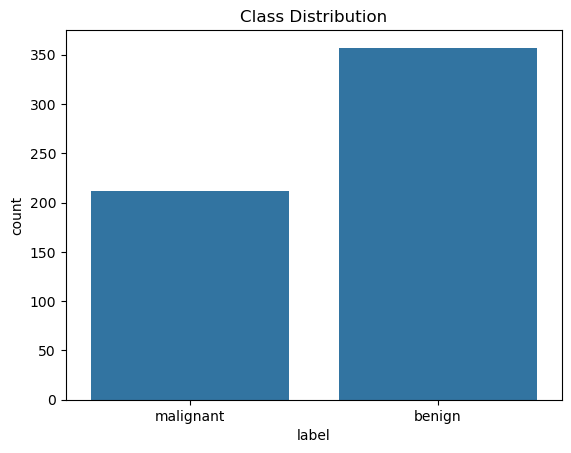

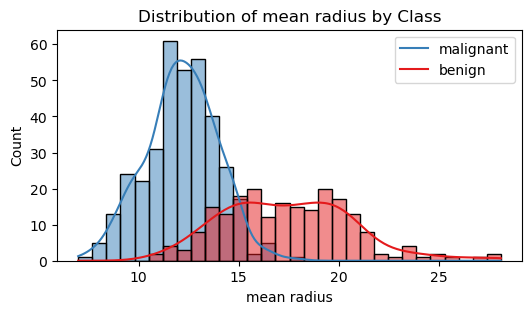

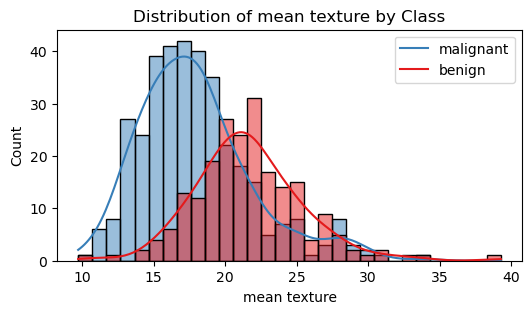

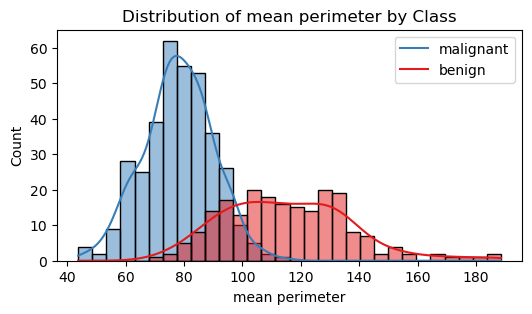

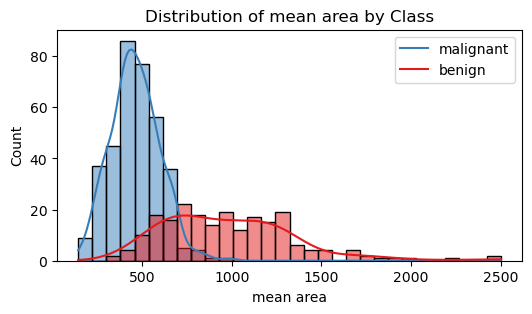

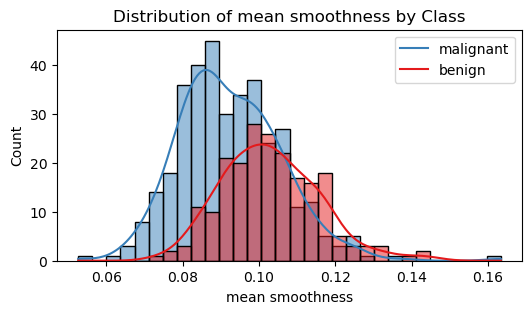

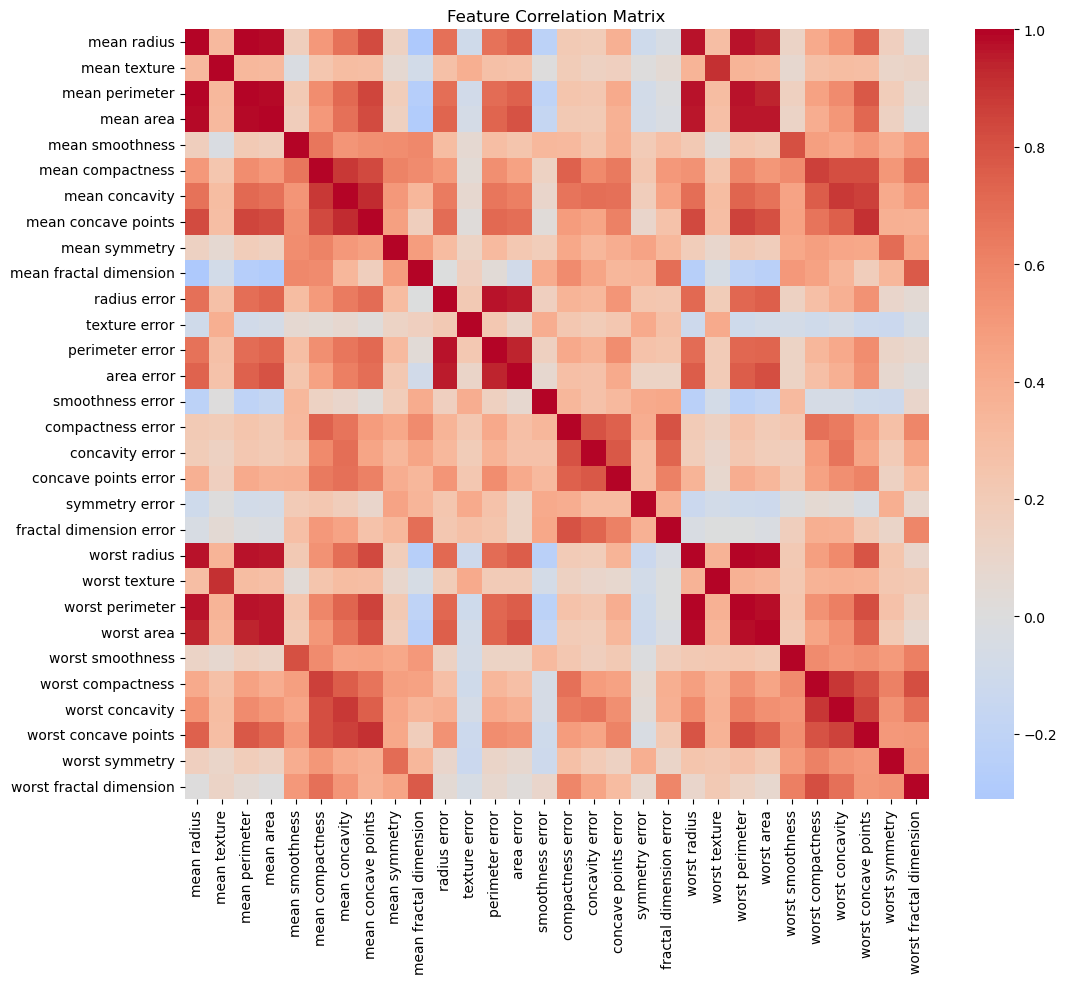

In [3]:
# 3. Data Visualization (EDA)

# Class distribution
sns.countplot(x=y.map({0: 'malignant', 1: 'benign'}))
plt.title('Class Distribution')
plt.show()

# Feature distributions for a few important features
features_to_plot = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
for feature in features_to_plot:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df, x=feature, hue='label', bins=30, kde=True, palette='Set1')
    plt.title(f'Distribution of {feature} by Class')
    plt.legend(labels=data.target_names)
    plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [4]:
# 4. Data Preprocessing & Train/Test Split

# Stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling for ML algorithms (not for trees, but good for dashboard and consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for explainability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("X_train shape:", X_train_scaled_df.shape)
print("X_test shape:", X_test_scaled_df.shape)

X_train shape: (455, 30)
X_test shape: (114, 30)


In [5]:
# 5. Model Building & Training

# RandomForest is robust, works well, and is explainable using tree-based XAI methods
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1  # Use all CPU cores
)
model.fit(X_train_scaled_df, y_train)

print("Random Forest model trained.")

Random Forest model trained.


Accuracy: 0.9474
ROC AUC: 0.9940

Classification Report:
               precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        42
      benign       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



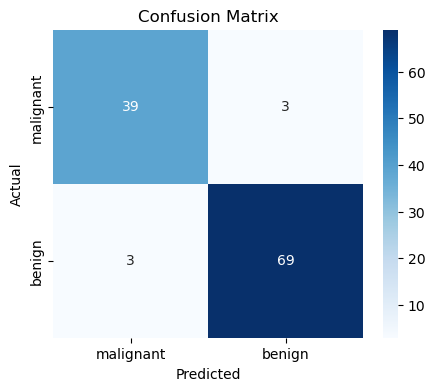

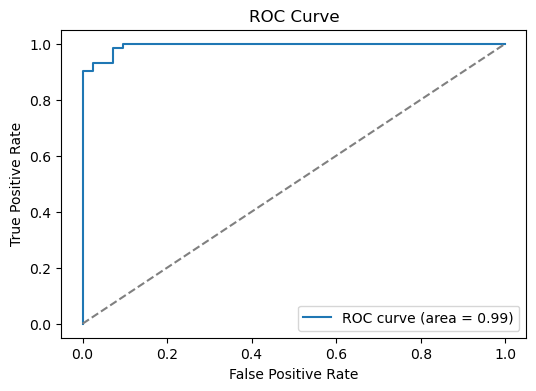

In [6]:
# 6. Model Evaluation

y_pred = model.predict(X_test_scaled_df)
y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=data.target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

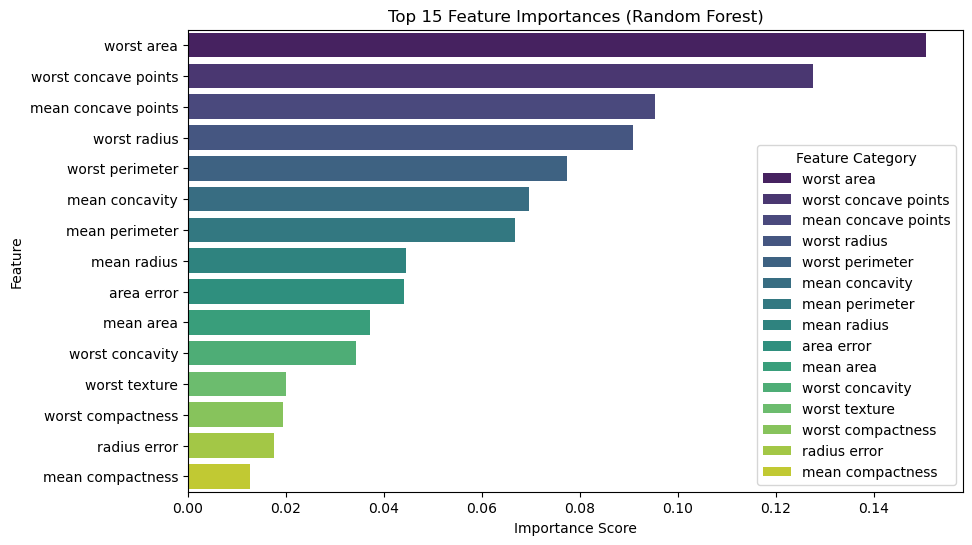

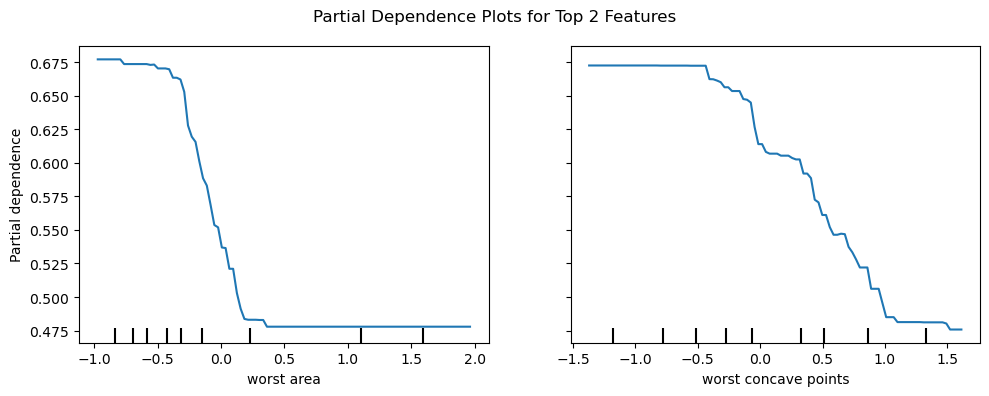

In [7]:
# 7. Global Explainability: Feature Importance & Partial Dependence

# --- Feature importance from Random Forest ---

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X.columns[indices]

# Create a DataFrame for easier plotting and coloring
top_n = 15
df_importance = pd.DataFrame({
    'Feature': features_sorted[:top_n],
    'Importance': importances[indices][:top_n]
})
# Create a fake hue (each feature is a category, so each bar gets a different color)
df_importance['Feature Category'] = df_importance['Feature']

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_importance,
    x='Importance',
    y='Feature',
    hue='Feature Category',
    dodge=False,
    palette='viridis',
    legend=True  # Set True if you want to show the legend (but it will be long)
)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Partial dependence plot for top 2 features
from sklearn.inspection import PartialDependenceDisplay

top2features = features_sorted[:2].tolist()
fig, ax = plt.subplots(figsize=(10,4))
PartialDependenceDisplay.from_estimator(model, X_test_scaled_df, top2features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 2 Features")
plt.tight_layout()
plt.show()

In [8]:
# 8. Explainable AI: Interactive Dashboard
explainer = ClassifierExplainer(
    model,
    X_test_scaled_df,
    y_test,
    labels=list(data.target_names)
)

# Launching ExplainerDashboard
# whatif and contributions tabs are very useful for global and local explanation
db = ExplainerDashboard(explainer, whatif=True, contributions=True)

# Stop with Kernel Interrupt when done (or use .stop() in new cell).
db.run(host="127.0.0.1", port=8050, mode="jupyterlab")

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will s

C:\Users\sayat\anaconda3\envs\xai_dashboard\Lib\site-packages\dash\dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8050))
